In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import random
import math
import decimal
import re
import pandas as pd
import numpy as np
import itertools 

from sklearn import decomposition

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics


from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

set random seed

In [2]:
#random seed in jupyter notebooks have scope of cell only and it's not applicable for whole notebook
# so even after this we need to set random_state explicility
random.seed(11915043)

## P1 : IRIS – HIERARCHICAL FISHER

In [3]:
iris = pd.read_csv('DMG-2 Assignment Data Files/iris/iris.data', header=None, names =
                   ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class
129,7.2,3.0,5.8,1.6,Iris-virginica
108,6.7,2.5,5.8,1.8,Iris-virginica
132,6.4,2.8,5.6,2.2,Iris-virginica
32,5.2,4.1,1.5,0.1,Iris-setosa
40,5.0,3.5,1.3,0.3,Iris-setosa


#### Two classes in IRIS are more “similar” to each other. Find which ones using scatter plots. Lets say class 1 and class 2.

### As seen in plots below 'Iris-versicolor' and 'Iris-virginica' are more similar to each other

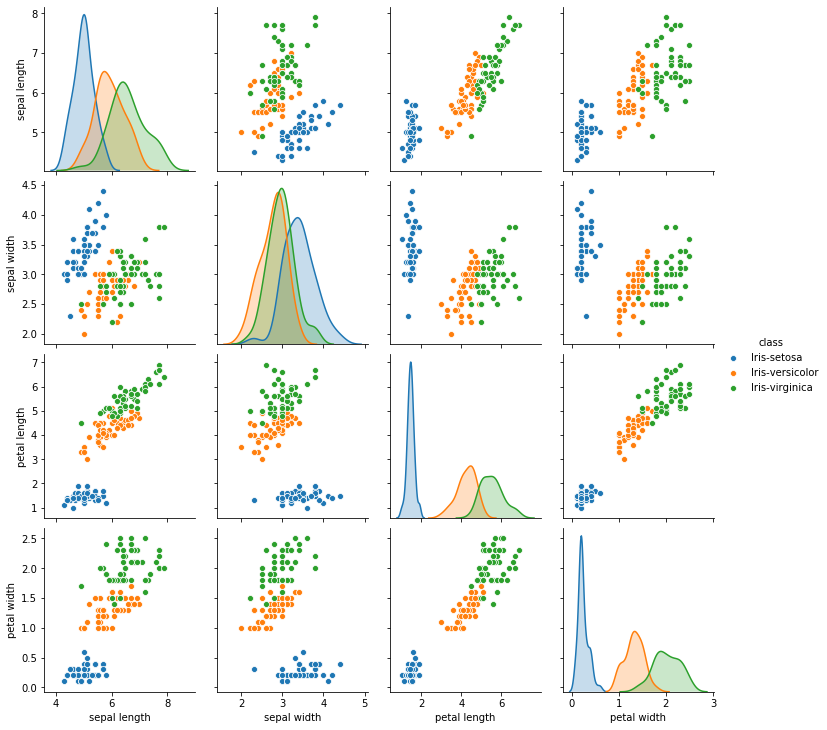

In [4]:
sns.pairplot(iris, hue = 'class')

#### Lets create a “meta class” combining class 1 and class 2 (or whichever are the two most similar classes). Lets call it class 4.

In [5]:
iris['versi-virgi'] = np.where((iris['class'] == 'Iris-versicolor') | (iris['class'] == 'Iris-virginica'), 1, 0)
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class,versi-virgi
145,6.7,3.0,5.2,2.3,Iris-virginica,1
69,5.6,2.5,3.9,1.1,Iris-versicolor,1
63,6.1,2.9,4.7,1.4,Iris-versicolor,1
93,5.0,2.3,3.3,1.0,Iris-versicolor,1
51,6.4,3.2,4.5,1.5,Iris-versicolor,1


In [6]:
train, test = train_test_split(iris, test_size=0.3, random_state=11915043)

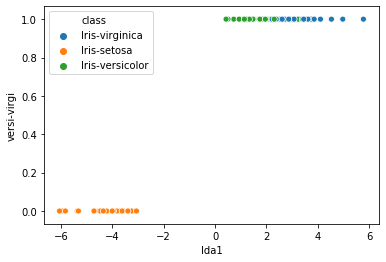

In [7]:
#Ref https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

lda = LinearDiscriminantAnalysis()
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'versi-virgi'

lda1 = lda.fit(train[features], train[target])
lda1_dis = lda1.transform(train[features])
train['lda1'] = lda1_dis

ax = sns.scatterplot(x="lda1", y="versi-virgi", hue="class", data=train)


#### Create the second Fisher projection by trying to discriminate class 1 from class 2 (the original two similar classes)

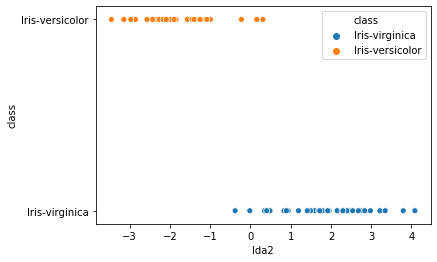

In [8]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'class'

train = train[(train['class'] == 'Iris-versicolor') | (train['class'] == 'Iris-virginica')]
lda = LinearDiscriminantAnalysis(n_components=1)
lda2 = lda.fit(train[features], train[target])
lda2_dis = lda2.transform(train[features])
train['lda2'] = lda2_dis

ax = sns.scatterplot(x="lda2", y="class", hue="class", data=train)

#### Now project the entire data in these two projections and color code the class points.

In [9]:
test['lda1'] = lda1.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])
test['lda2'] = lda2.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])

#### Comment on what you observed and did.

### Plot how the original four features were classifying the data

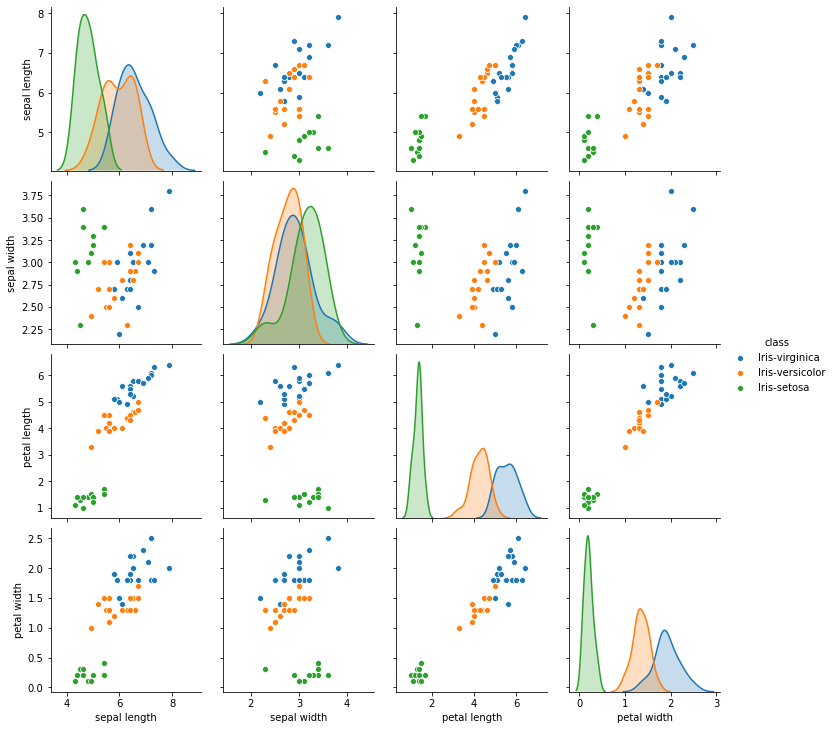

In [10]:
sns.pairplot(hue='class', data=test[['sepal length', 'sepal width', 'petal length', 'petal width', 'class']])

### We can clearly see the difference between all three classes ie. setosa, versicolor and vigginica using lda projections. Which was not clear earlier using original feature. Hence it's useful projection

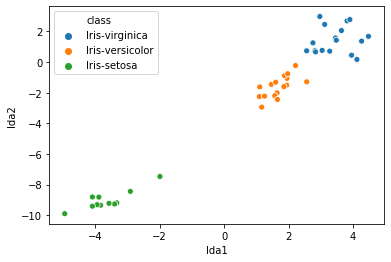

In [11]:
ax = sns.scatterplot(x="lda1", y="lda2", hue="class", data=test)

## P2 : MUSHROOM information gain

#### Take the MUSHROOM training data. There are 20+ features and 2 classes. We want to find the BEST feature using the three purity measures: Accuracy, Gini Index, and Entropy.

In [12]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Logic Used to Answer : For each feature, partition the data into k regions where k is the number of values the feature can take.

- Take one feature at a time from dataframe
- create a subset of data with that feature and class labels
- Groupby count to partition data into K features where k is no of values feature can take

#### Measure the Information gain due to each feature. Generate a table with the following columns:
- Feature_name
- Accuracy
- GINI index
- Entropy (NOTE: Use log_k for a feature with k values)

In [13]:
#define a empty dataframe for result set
result_set = pd.DataFrame(columns = ['Feature', 'Accuracy', 'Gini', '1-Entropy'])
result_set

,Feature,Accuracy,Gini,1-Entropy


In [14]:
#No. of rows
total_rows_data = mushroom.shape[0]

for column in col_names[1:] :
    df_feature_subset = mushroom[[column,'class']]
    feature_partition = df_feature_subset.groupby([column,'class']).size().unstack(fill_value=0)
    
    #Ref : https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb
    for index, row in feature_partition.iterrows():
        partition_total_sum = row['e'] + row['p']
        prob_e_class = row['e']/partition_total_sum
        prob_p_class = row['p']/partition_total_sum

        # calculate accuracy for each partition
        if(row['e'] > row['p']) :
            feature_partition.at[index,'Parition Accuracy'] = prob_e_class
        else :
            feature_partition.at[index,'Parition Accuracy'] = prob_p_class
        feature_partition.at[index,'Weighted Accuracy'] = partition_total_sum*feature_partition.loc[index,'Parition Accuracy']/total_rows_data

        #calculate gini index for each partition
        feature_partition.at[index,'Gini Index'] = prob_e_class**2 + prob_p_class**2
        feature_partition.at[index,'Weighted Gini Index'] = partition_total_sum*feature_partition.loc[index,'Gini Index']/total_rows_data

        #calculate entropy for each partition
        entropy = 0
        num_of_partitions = feature_partition.shape[0]
        if(num_of_partitions > 1) :
            #print(num_of_partitions)
            if(prob_e_class > 0) :
                entropy += prob_e_class*math.log(prob_e_class, num_of_partitions)
            if(prob_p_class > 0) :
                entropy += prob_p_class*math.log(prob_p_class, num_of_partitions)
        feature_partition.at[index,'Entropy'] = -1*entropy
        feature_partition.at[index,'Weighted Entropy'] = partition_total_sum*feature_partition.loc[index,'Entropy']/total_rows_data
    print()
    print(feature_partition)
    
    result_set = result_set.append({'Feature' : column, 
                       'Accuracy': feature_partition[['Weighted Accuracy']].sum()[0].round(4),
                       'Gini' : feature_partition[['Weighted Gini Index']].sum()[0].round(4),
                       '1-Entropy': 1-feature_partition[['Weighted Entropy']].sum()[0].round(4)}, ignore_index=True)
    
result_set.head()


class         e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
cap-shape                                                                 
b           404    48           0.893805           0.049729    0.810165   
c             0     4           1.000000           0.000492    1.000000   
f          1596  1556           0.506345           0.196455    0.500081   
k           228   600           0.724638           0.073855    0.600924   
s            32     0           1.000000           0.003939    1.000000   
x          1948  1708           0.532823           0.239783    0.502155   

class      Weighted Gini Index   Entropy  Weighted Entropy  
cap-shape                                                   
b                     0.045076  0.188912          0.010511  
c                     0.000492 -0.000000         -0.000000  
f                     0.194024  0.386808          0.150076  
k                     0.061246  0.328459          0.033477  
s                     0.003939 -

y                                 0.014648  

class                      e     p  Parition Accuracy  Weighted Accuracy  \
stalk-color-above-ring                                                     
b                          0   432           1.000000           0.053176   
c                          0    36           1.000000           0.004431   
e                         96     0           1.000000           0.011817   
g                        576     0           1.000000           0.070901   
n                         16   432           0.964286           0.053176   
o                        192     0           1.000000           0.023634   
p                        576  1296           0.692308           0.159527   
w                       2752  1712           0.616487           0.338749   
y                          0     8           1.000000           0.000985   

class                   Gini Index  Weighted Gini Index   Entropy  \
stalk-color-above-ring                          

,Feature,Accuracy,Gini,1-Entropy
0,cap-shape,0.5643,0.5308,0.6324
1,cap-surface,0.5805,0.5200,0.5148
2,cap-color,0.5953,0.5245,0.7101
3,bruises,0.7440,0.6262,0.1933
4,odor,0.9852,0.9715,0.9707


In [15]:
result_set.tail()

,Feature,Accuracy,Gini,1-Entropy
17,ring-number,0.5382,0.5237,0.3939
18,ring-type,0.7755,0.6824,0.7067
19,spore-print-color,0.8680,0.7835,0.8365
20,population,0.7218,0.6193,0.6916
21,habitat,0.6903,0.5974,0.7000


#### Plot accuracy vs. 1-Entropy scatter plot where each point is a feature.

We can see that Accuracy and '1-Entropy' are curvi linear, as Accuracy increases '1-Entropy' also increases for that feature, however there are 5 features which are outlier to this trend

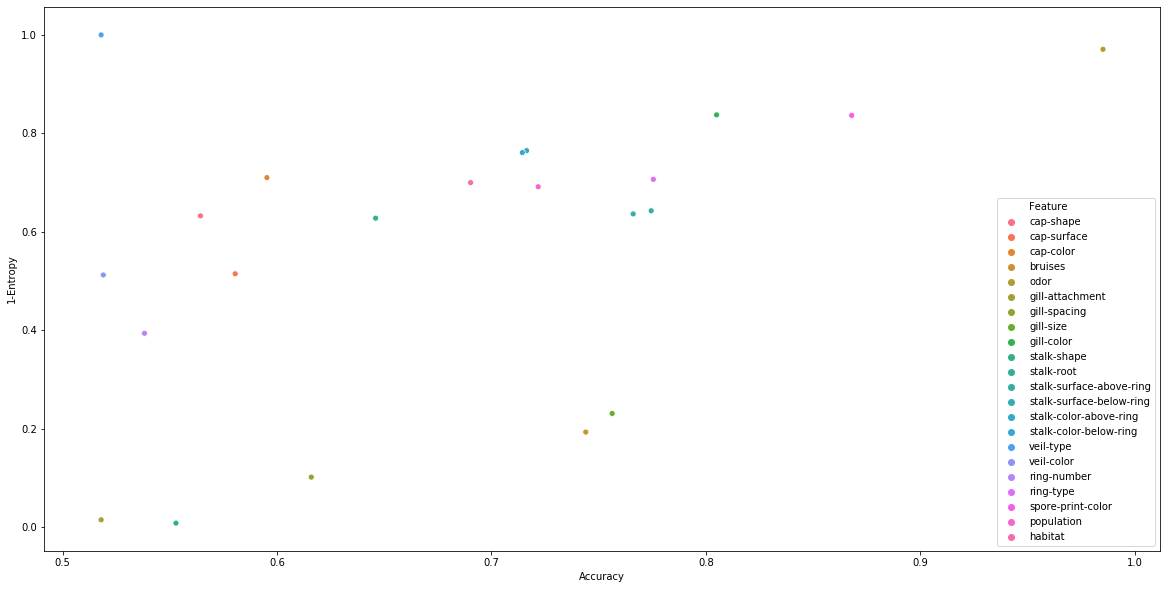

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x='Accuracy', y='1-Entropy', hue='Feature', data=result_set)

### veil-type, odor, gill-color, spore-print-color are top features which alone can define the whole data

In [17]:
result_set.sort_values(by='1-Entropy', ascending=False)

,Feature,Accuracy,Gini,1-Entropy
15,veil-type,0.5180,0.5006,1.0000
4,odor,0.9852,0.9715,0.9707
8,gill-color,0.8050,0.7321,0.8376
19,spore-print-color,0.8680,0.7835,0.8365
13,stalk-color-above-ring,0.7164,0.6382,0.7649
14,stalk-color-below-ring,0.7144,0.6329,0.7610
2,cap-color,0.5953,0.5245,0.7101
18,ring-type,0.7755,0.6824,0.7067
21,habitat,0.6903,0.5974,0.7000
20,population,0.7218,0.6193,0.6916


## P3 : MUSHROOM NB/DT

In [18]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

X = mushroom.loc[:, mushroom.columns != 'class']
X = pd.get_dummies(X)
y = mushroom.loc[:, mushroom.columns == 'class']

#### Build Naive Bayes and Decision Tree classifiers on the MUSHROOM training dataset.

In [19]:
#use a classic 70:30 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11915043)

df = pd.DataFrame(columns=['lambda','accuracy', 'type'])
for i in range(0,51) :
    nbc = BernoulliNB(alpha=i)
    nbc.fit(X_train, y_train.values.ravel())
    train_score = accuracy_score(y_train, nbc.predict(X_train))
    test_score = accuracy_score(y_test, nbc.predict(X_test))
    df = df.append({'lambda' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
    df = df.append({'lambda' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
    print(i, train_score, test_score)

0 0.9943721421034118 0.9967186218211649
1 0.9395005276116778 0.9364232977850697
2 0.934048540274358 0.9306808859721083
3 0.9305311290889905 0.9290401968826907
4 0.9287724234963067 0.9245283018867925
5 0.9277172001406965 0.9232977850697293
6 0.9264861062258178 0.9216570959803118
7 0.9252550123109391 0.9212469237079574
8 0.9243756595145972 0.9191960623461854
9 0.923320436158987 0.9175553732567678
10 0.9220893422441083 0.9163248564397046
11 0.9215617305663032 0.9150943396226415
12 0.9208582483292297 0.9138638228055783
13 0.9201547660921562 0.9134536505332239
14 0.9192754132958143 0.9118129614438064
15 0.9187478016180092 0.9105824446267432
16 0.918220189940204 0.9101722723543888
17 0.9171649665845938 0.9101722723543888
18 0.9169890960253254 0.9097621000820345
19 0.9166373549067885 0.9097621000820345
20 0.9164614843475202 0.9089417555373257
21 0.9157580021104467 0.9089417555373257
22 0.9152303904326415 0.9089417555373257
23 0.9147027787548364 0.9085315832649713
24 0.914526908195568 0.908121

#### In Naïve Bayes classifier plot the value of lambda (x axis) for Laplacian smoothing against training and test set accuracy.

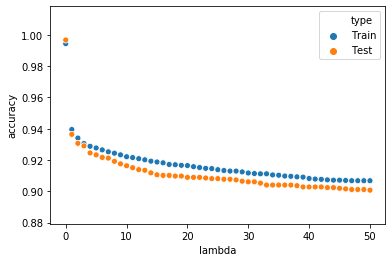

In [20]:
x = sns.scatterplot(x="lambda", y='accuracy', hue='type', data=df)

### For decision tree classifier plot the Size Threshold (x axis) against training and test set accuracy.

In [21]:
df = pd.DataFrame(columns=['size threshold','accuracy', 'type'])
for i in range(4,65,4) :
    dtc = DecisionTreeClassifier(min_samples_split=i)
    dtc.fit(X_train, y_train)
    train_score = accuracy_score(y_train, dtc.predict(X_train))
    test_score = accuracy_score(y_test, dtc.predict(X_test))
    df = df.append({'size threshold' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
    df = df.append({'size threshold' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
    print(i, train_score, test_score)

4 1.0 1.0
8 1.0 1.0
12 1.0 1.0
16 1.0 1.0
20 1.0 1.0
24 1.0 1.0
28 1.0 1.0
32 1.0 1.0
36 1.0 1.0
40 0.9982412944073162 0.9975389663658737
44 0.9982412944073162 0.9975389663658737
48 0.9982412944073162 0.9975389663658737
52 0.9982412944073162 0.9975389663658737
56 0.9982412944073162 0.9975389663658737
60 0.9982412944073162 0.9975389663658737
64 0.9982412944073162 0.9975389663658737


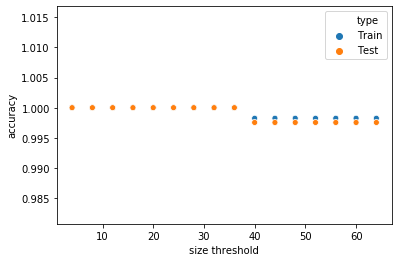

In [22]:
ax = sns.scatterplot(x="size threshold", y='accuracy', hue='type', data=df)
#ax.set_xticks(range(0,68,4))

### Find the best values of lambda and SizeThreshold where the test set accuracies starts to decrease.

Looking at plots above, we can say -

- Naive Bayes - Even with very small lambda value for smoothening we are getting best accuracy, ie lambda- 1.0e-10, since 0 is numerically not possible. The next best is lambda = 1
- Decision Tree Classifier - Best size threshold : 36
    
Comparision -
- Naive bayes classifier are surprisingly giving better result on set set as lambda increases, compared to train set which creates doubt.
- Decision Tree Classifier are performing better than Naive Bayes with a test set accuracy of 1 at size threshold of 36, just a depth of 8.

## P4 : MNIST Bayesian

#### Take the MNIST dataset. Lets call it D0 dataset

In [23]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')
mnist.head()

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [24]:
target_names = pd.Series(mnist.label.unique()).apply(str)
print(target_names)
n_components = 9

0    1
1    0
2    4
3    7
4    3
5    5
6    8
7    9
8    2
9    6
dtype: object


#### Do a 9 dimensional PCA projection . Lets call it D1 dataset

In [25]:
pca = decomposition.PCA()
pca.n_components = n_components
pca_data = pca.fit_transform(mnist_data)

#### Do a 9 dimensional FISHER projection . Lets call it D2 dataset

In [26]:
model = LinearDiscriminantAnalysis(n_components=n_components)
model.fit(mnist_data, mnist_label.values.ravel())
mnist_fisher_proj_data = model.transform(mnist_data)

#### Build a Bayesian classifier on D1 (single Gaussian per class)
- Diagonal Covariance matrix ( i.e.set non diagonals to zero)
- Full Covariance matrix

Ref :
#https://stats.stackexchange.com/questions/105140/gaussian-naive-bayes-really-equivalent-to-gmm-with-diagonal-covariance-matrices
#https://scikit-learn.org/stable/modules/mixture.html#bgmm
#https://www.programcreek.com/python/example/99731/sklearn.mixture.BayesianGaussianMixture


In [27]:
def build_classifier(X_train, X_test, y_train, y_test, n_gaussians, target_names) :
    
    #Build bayesian classifier with diagnonal covariance matrix on fisher projection data
    gnb_model = GaussianNB()
    gnb_model.fit(X_train, y_train)
    y_pred = gnb_model.predict(X_test)
    nb_diag_acc = accuracy_score(y_test, y_pred)
    print("Gaussian Naive Bayes diagonal matrix : ")
    print("Train set accuracy score : ", accuracy_score(y_test, y_pred))
    print("Test set accuracy score : ", nb_diag_acc)
    print("Classification report : ")
    print(classification_report(y_test, y_pred, target_names=target_names))

    #Build bayesian classifier with full covariance matrix on fisher projection data
    bgm = BayesianGaussianMixture(
                n_components = n_gaussians,
                covariance_type='full')
    bgm.fit(X_train, y_train)
    y_pred = bgm.predict(X_test)
    #print(y_pred)
    #print(y_test)
    b_full_acc = accuracy_score(y_test, y_pred)
    print("\nBayesian Gaussian mixture full covariance matrix : ")
    print("Train set accuracy : ", accuracy_score(y_test, y_pred))
    print("Test set accuracy : ", b_full_acc)
    print("Classification report : ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    #return test accuracies of both model
    return nb_diag_acc, b_full_acc

In [28]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2, random_state=11915043)
print(build_classifier(X_train, X_test, y_train, y_test, 10, target_names))

Gaussian Naive Bayes diagonal matrix : 
Train set accuracy score :  0.7566666666666667
Test set accuracy score :  0.7566666666666667
Classification report : 
              precision    recall  f1-score   support

           1       0.89      0.83      0.86       827
           0       0.85      0.92      0.88       931
           4       0.83      0.74      0.78       865
           7       0.72      0.72      0.72       844
           3       0.64      0.69      0.66       814
           5       0.57      0.65      0.61       720
           8       0.87      0.84      0.86       851
           9       0.86      0.82      0.84       915
           2       0.70      0.73      0.72       806
           6       0.63      0.59      0.61       827

   micro avg       0.76      0.76      0.76      8400
   macro avg       0.76      0.75      0.75      8400
weighted avg       0.76      0.76      0.76      8400


Bayesian Gaussian mixture full covariance matrix : 
Train set accuracy :  0.039285

### Build a Bayesian classifier on D2 (single Gaussian per class)
- Diagonal Covariance matrix ( i.e.set non diagonals to zero)
- Full Covariance matrix

In [29]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], test_size=0.2, 
                                                    random_state = 11915043)
print(build_classifier(X_train, X_test, y_train, y_test, 10, target_names))

Gaussian Naive Bayes diagonal matrix : 
Train set accuracy score :  0.8776190476190476
Test set accuracy score :  0.8776190476190476
Classification report : 
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       827
           0       0.94      0.92      0.93       931
           4       0.86      0.86      0.86       865
           7       0.88      0.84      0.86       844
           3       0.90      0.88      0.89       814
           5       0.80      0.84      0.82       720
           8       0.93      0.91      0.92       851
           9       0.92      0.87      0.90       915
           2       0.77      0.83      0.80       806
           6       0.82      0.88      0.85       827

   micro avg       0.88      0.88      0.88      8400
   macro avg       0.88      0.88      0.88      8400
weighted avg       0.88      0.88      0.88      8400


Bayesian Gaussian mixture full covariance matrix : 
Train set accuracy :  0.079642

### Compare the test accuracies of the four classifiers and comment.

diagonal covariance matrix - 
- PCA projection - test set accuracy is 0.76
- Fisher projection - test set accuracy is 0.88

If we look at classification matrix for test set, we see that on PCA data, digits 7,3,5 are performing poorly which improves with flscore of 0.83-0.9 range when doing classification modeling on fisher projection data


full covariance matrix - 
- PCA projection - test set accuracy is 0.039
- Fisher projection - test set accuracy is 0.079

## P5 : MNIST KNN / Parzen window

#### Take the two datasets D1 and D2 from P4.

#### Build k Nearest neighbors classifier with:
- K = 1, 3, 5, 7, 9, 11, 13, 15, 17
- Plot training and test accuracy with these values of k on x axis

In [30]:
def build_knn(X_train, X_test, y_train, y_test) :
    df = pd.DataFrame(columns=['k','accuracy', 'type'])
    for i in range(1,18,2) :
        knn_model = KNeighborsClassifier(n_neighbors=i)
        knn_model.fit(X_train, y_train)
        train_score = round(accuracy_score(y_train, knn_model.predict(X_train)),4)
        test_score = round(accuracy_score(y_test, knn_model.predict(X_test)),4)
        df = df.append({'k' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
        df = df.append({'k' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
        print(i, train_score, test_score)
    return df

### kNN on PCA data (D1)

1 1.0 0.8895
3 0.9487 0.8986
5 0.9383 0.9071
7 0.9332 0.9112
9 0.9282 0.9111
11 0.9253 0.9094
13 0.9223 0.9083
15 0.9212 0.9086
17 0.9185 0.9092


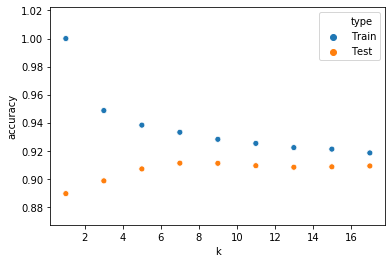

In [31]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2, 
                                                    random_state=11915043)
df = build_knn(X_train, X_test, y_train, y_test)
sns.scatterplot(x="k", y='accuracy', hue='type', data=df)

### kNN on fisher projection data (D2)

1 1.0 0.8989
3 0.9478 0.9124
5 0.9388 0.915
7 0.9339 0.9164
9 0.9315 0.9145
11 0.9287 0.9144
13 0.9277 0.9149
15 0.9262 0.9129
17 0.9251 0.9135


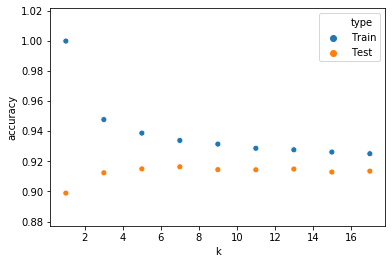

In [32]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], test_size=0.2, 
                                                    random_state=11915043)
df = build_knn(X_train, X_test, y_train, y_test)
sns.scatterplot(x="k", y='accuracy', hue='type', data=df)

### Build Parzen window classifier with:
- Sigma = 0.1, 0.2, 0.3, …, 3.0
- Plot training and test accuracies with these values of sigma.

In [33]:
sigma_list = []
for i in np.arange(0.1, 3.1, 0.1) :
    sigma_list.append(round(i,1))
classes = np.sort(y_train.unique())

def predict_accuracy(kde_models, X) :
    predict_accuracy = 0
    for model in kde_models :
        log_prob = model.score_samples(X)
        prob_X = np.sum(np.exp(log_prob))
        if(prob_X > predict_accuracy) :
            predict_accuracy = prob_X
    return predict_accuracy

#Adapted from : https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
def build_parzen_classifier(X_train, X_test, y_train, y_test) :
    df = pd.DataFrame(columns=['sigma','accuracy', 'type'])
    for i in sigma_list :
        kde_models = []
        for class_label in classes :
            #print("kde for class : ", class_label)
            X = pca_data[mnist[mnist['label']==class_label].index]
            kde_model = KernelDensity(bandwidth=i, kernel='gaussian')
            kde_model.fit(X)
            kde_models.append(kde_model)
        train_score = predict_accuracy(kde_models, X_train)
        test_score = predict_accuracy(kde_models, X_test)
        
        df = df.append({'sigma' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
        df = df.append({'sigma' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
        print(i, train_score, test_score)
    return df

### Parzen classifier pca data (D1)

0.1 207754.61222002213 55182.87807727062
0.2 405.77072699223174 107.77905874466936
0.3 10.555027801657433 2.8035806572814543
0.4 0.7925209511567064 0.2105059741106836
0.5 0.10637036145665202 0.028253633575562733
0.6 0.02061528867511225 0.005475743471252879
0.7 0.005148352964334133 0.0013674831614747896
0.8 0.0015478924827279522 0.00041114448068493083
0.9 0.0005362509679244791 0.0001424366538272371
1.0 0.00020775461222002624 5.518287807727167e-05
1.1 8.81082362484122e-05 2.340292716751003e-05
1.2 4.0264235693579006e-05 1.069481146729088e-05
1.3 1.9591175869083307e-05 5.20372307416721e-06
1.4 1.0055376883465235e-05 2.670865549755499e-06
1.5 5.404174234448712e-06 1.435433296528138e-06
1.6 3.023227505328069e-06 8.030165638377634e-07
1.7 1.7519043122867915e-06 4.653332170820048e-07
1.8 1.0473651717275167e-06 2.7819658950632485e-07
1.9 6.438256359011099e-07 1.7101017007182527e-07
2.0 4.057707269922448e-07 1.0777905874467283e-07
2.1 2.61563428559379e-07 6.947534224837816e-08
2.2 1.72086398922

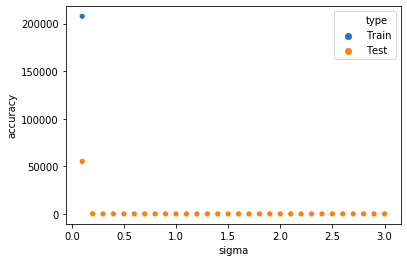

In [34]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2)
df = build_parzen_classifier(X_train, X_test, y_train, y_test)
sns.scatterplot(x="sigma", y='accuracy', hue='type', data=df)

### Parzen classifier fisher projection data (D2)

0.1 0 0
0.2 4.180604314400227e-155 3.543840697365687e-157
0.3 6.091418141662426e-76 1.3638441339754049e-75
0.4 5.267930823589812e-47 3.3559255760340885e-49
0.5 5.042714395219737e-35 3.1823008225772225e-36
0.6 6.150716102030815e-28 1.2420069253313746e-28
0.7 1.9709520103691598e-24 4.531913042507462e-25
0.8 1.07516288497189e-22 2.7973775751414435e-23
0.9 6.44480811786607e-21 1.6974634331313358e-21
1.0 2.3429241273765993e-20 5.7473293833950314e-21
1.1 4.6953043574132237e-20 1.1658997667946759e-20
1.2 1.0187639999347472e-19 2.224614840904473e-20
1.3 1.1307983573390784e-19 2.8060251543543405e-20
1.4 9.297822395785718e-20 2.4663560174089207e-20
1.5 6.697146630650185e-20 1.67465079055131e-20
1.6 4.687666163047527e-20 1.1486102723292086e-20
1.7 3.22484590879155e-20 7.81357174964774e-21
1.8 2.2439863653252653e-20 5.6836577302838945e-21
1.9 1.54019096548494e-20 3.867477967540979e-21
2.0 1.0292676869572286e-20 2.5014027591961316e-21
2.1 6.980582952396916e-21 1.747483697535453e-21
2.2 4.8202083474

,sigma,accuracy,type
0,0.1,0,Train
1,0.1,0,Test
2,0.2,4.1806e-155,Train
3,0.2,3.54384e-157,Test
4,0.3,6.09142e-76,Train


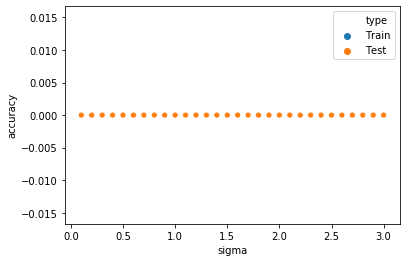

In [35]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], 
                                                    test_size=0.2, random_state=11915043)
df = build_parzen_classifier(X_train, X_test, y_train, y_test)
sns.scatterplot(x="sigma", y='accuracy', hue='type', data=df)
df.head()

#### Comment on the optimal k and optimal sigma and compare those classifiers across D1 and D2 and see which one has highest test accuracy.

If we look at scatter plot for train and test set, we see that on fisher projection data we get marginal higher accuracy for K=9 on both train and test set, with k nearest neighbours

PCA data (D1) - 
- K nearest neighbour - test set accuracy is .91, for k=9

Fisher projection data (D2) - 
- K nearest neighbour - test set accuracy is 0.9145, for k=9


## P6 : News group Text Classifier

In [36]:
#check sample of categories and document nos.
#This file doesn't seem to be of any use, as all document Ids belong to same newsgroup
categories = pd.read_csv("DMG-2 Assignment Data Files/Newsgroup/list.csv")
categories.sample(5)

,newsgroup,document_id
203,talk.religion.misc,83781
227,talk.religion.misc,83830
102,talk.religion.misc,83509
362,talk.religion.misc,84121
32,talk.religion.misc,82801


In [37]:
#Ref :
#https://stackoverflow.com/questions/35672809/how-to-read-a-list-of-txt-files-in-a-folder-in-python
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1
#https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925
#https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
#https://github.com/gokriznastic/20-newsgroups_text-classification/blob/master/Multinomial%20Naive%20Bayes-%20BOW%20with%20TF.ipynb


#Read all documents one by one and create two dataframes
#One for finding probability and other for running naive bayes

df = pd.DataFrame(columns=['data','document'])
df_docs = pd.DataFrame(columns=['doc part','document'])
text_files = glob.glob("DMG-2 Assignment Data Files/Newsgroup/*.txt")

#read all text files and create a dataframe of whole dataset
for file in text_files :
    print("Reading file : ", file)
    category = file[file.rfind('/')+1:-4]
    with open(file, 'r', encoding='windows-1252') as current_file :
        data = current_file.read()
        df = df.append({'data':data, 'document': category}, ignore_index=True)
        
        #split each file at \n to create multiple documents from each data
        #this dataset will be used for naive bayes
        docs = data.split('\n\n')
        df_temp = pd.DataFrame(docs, columns=['doc part'])
        df_temp['document'] = category
        df_docs = df_docs.append(df_temp, ignore_index=True)
        
df.sample(5)

Reading file :  DMG-2 Assignment Data Files/Newsgroup/sci.crypt.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.sys.mac.hardware.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/misc.forsale.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/soc.religion.christian.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/rec.sport.baseball.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/rec.sport.hockey.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.sys.ibm.pc.hardware.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/talk.politics.guns.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/rec.autos.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/alt.atheism.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.os.ms-windows.misc.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/sci.electronics.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.windows.x.txt
Reading file :  DMG-2

,data,document
2,Newsgroup: misc.forsale\ndocument_id: 70337\nF...,misc.forsale
10,Newsgroup: comp.os.ms-windows.misc\ndocument_i...,comp.os.ms-windows.misc
14,Newsgroup: talk.politics.mideast\ndocument_id:...,talk.politics.mideast
3,Newsgroup: soc.religion.christian\ndocument_id...,soc.religion.christian
1,Newsgroup: comp.sys.mac.hardware\ndocument_id:...,comp.sys.mac.hardware


In [38]:
stop_words = stopwords.words('english')

#important to add email ids to remove training bias, as documents contain emails from specific sources
stop_words.extend(["Newsgroup","document_id","From","Subject","document","umd","edu","wam","mri","com"])

'''
Return cleaned array of words from data
'''
def clean_get_words(data, tokenize=False) :
    # replace all non alphabetical characters with space
    data = re.sub("[^a-zA-Z]", ' ', data)
    
    #convert data to lowercase
    data = data.lower()
    
    # remove all words less than 3 characters
    data = re.sub(r'\b\w{1,2}\b', '', data)
    
    # get all unique words from data
    words = re.sub("[^\w]", " ",  data).split()
    words = [word for word in words if word not in stop_words]
    
    #stemming at per DMG2 session 5 explaination before building NLP
    lancaster = LancasterStemmer()
    data = " ".join(words)
    lancaster.stem(data)
    
    #tokenize words are used during naive bayes
    if(tokenize) :
        return data.split(" ")
    
    return data

#### Build a Naïve Bayes Classifier on Newsgroup dataset

### DICTIONARY :
- Compute the document frequency of all words (how many documents each word occurred in)
- Sort this in descending order of document frequency
- Pick the top 5000 and 10000 words as the dictionary.

In [39]:
%%time

#clean each of the documents and get words from it
df['data'] = df['data'].map(clean_get_words)
#get unique words from each document
df['unique words data'] = df['data'].apply(lambda x: " ".join(set(x.split(' '))))

#create a count vector to create top 5k and 10k words
countVectorizer = CountVectorizer()
count_vec = countVectorizer.fit_transform(df['unique words data'])
word2vec = pd.DataFrame(count_vec.toarray(), columns=countVectorizer.get_feature_names())

CPU times: user 26.9 s, sys: 982 ms, total: 27.9 s
Wall time: 28 s


#### Compute the document frequency of all words (how many documents each word occurred in)

In [40]:
word2vec.index = df.document
word2vec.sample(5)

,aaa,aaaa,aaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaagggghhhh,aaaaarrrrgh,aaaahhh,aaaall,aaaarrgghhhh,...,zztop,zzum,zzvsi,zzx,zzy,zzz,zzzoh,zzzz,zzzzzz,zzzzzzt
document,,,,,,,,,,,,,,,,,,,,,
soc.religion.christian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
talk.politics.guns,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
talk.politics.misc,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
sci.space,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sci.med,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Dictionary : Sort this in descending order of document frequency

In [41]:
sum_matrix = word2vec.sum(axis=0)
term_document_frequency = sum_matrix.sort_values(ascending=False)

#### Dictionary : Pick the top 5000 and 10000 words as the dictionary.

In [42]:
top_5k = term_document_frequency[:5000]
print(top_5k)
print()
top_10k = term_document_frequency[:10000]
print(top_10k)

offer             20
third             20
world             20
later             20
late              20
                  ..
eve               13
rank              13
anon              13
ranks             13
specifications    13
Length: 5000, dtype: int64

offer          20
third          20
world          20
later          20
late           20
               ..
perpetuate      7
api             7
listings        7
clay            7
diagnostics     7
Length: 10000, dtype: int64


#### Learn P( w|c ) for all words and classes

Done it for top 10k and top 5k words only

In [43]:
#get all words in a given document, difference from above is set()
df['words'] = df['data'].apply(lambda x: " ".join(x.split(' ')))

#create a count vector to calculate probability of each word in given document(class)
countVectorizer = CountVectorizer()
count_vec = countVectorizer.fit_transform(df['words'])
word2vec = pd.DataFrame(count_vec.toarray(), columns=countVectorizer.get_feature_names())

#Take only top 5k and 10k words

word2vec_5k = word2vec[list(top_5k.index)]
word2vec_5k.index = df.document

word2vec_10k = word2vec[list(top_10k.index)]
word2vec_10k.index = df.document
word2vec_10k

,offer,third,world,later,late,upon,last,difference,works,different,...,slides,escaping,perot,evolving,depletion,perpetuate,api,listings,clay,diagnostics
document,,,,,,,,,,,,,,,,,,,,,
sci.crypt,34,60,232,94,68,92,186,90,82,202,...,0,0,0,4,0,2,10,0,0,0
comp.sys.mac.hardware,46,78,102,48,18,28,172,150,208,132,...,2,0,0,0,0,0,2,0,0,2
misc.forsale,668,12,130,14,18,24,128,12,144,28,...,0,0,0,0,0,0,2,0,4,8
soc.religion.christian,58,86,648,206,62,238,322,162,202,486,...,2,0,0,2,0,0,0,2,8,0
rec.sport.baseball,26,272,234,74,86,22,964,86,28,120,...,0,0,2,0,6,0,0,0,18,0
rec.sport.hockey,28,296,252,106,114,24,736,54,32,126,...,0,4,0,0,0,0,0,2,4,0
comp.sys.ibm.pc.hardware,34,66,74,58,6,20,172,144,232,182,...,0,0,0,0,0,0,0,0,0,16
talk.politics.guns,32,50,204,160,70,88,318,150,64,230,...,0,4,0,2,2,2,0,0,6,0
rec.autos,70,44,144,128,60,18,270,86,96,184,...,0,0,0,0,6,0,0,0,0,2


In [44]:
#total no. of words in each document
word2vec_5k.loc[:,"sum"] = word2vec_5k.sum(axis=1)

#calculate probability P(w|C) for all words across all classes
df_prob = word2vec_5k.loc[:, word2vec_5k.columns != 'sum'].div(word2vec_5k.loc[:,"sum"], axis=0)
df_prob

,offer,third,world,later,late,upon,last,difference,works,different,...,exclude,modules,mate,excluded,solving,eve,rank,anon,ranks,specifications
document,,,,,,,,,,,,,,,,,,,,,
sci.crypt,0.000134,0.000236,0.000913,0.000370,0.000268,0.000362,0.000732,0.000354,0.000323,0.000795,...,0.000008,0.000008,0.000024,0.000000,0.000031,0.000142,0.000008,0.000394,0.000000,0.000087
comp.sys.mac.hardware,0.000331,0.000562,0.000735,0.000346,0.000130,0.000202,0.001239,0.001081,0.001499,0.000951,...,0.000014,0.000043,0.000000,0.000000,0.000014,0.000014,0.000058,0.000000,0.000029,0.000101
misc.forsale,0.006167,0.000111,0.001200,0.000129,0.000166,0.000222,0.001182,0.000111,0.001329,0.000259,...,0.000000,0.000018,0.000018,0.000018,0.000055,0.000203,0.000000,0.000000,0.000000,0.000074
soc.religion.christian,0.000213,0.000315,0.002376,0.000755,0.000227,0.000873,0.001181,0.000594,0.000741,0.001782,...,0.000095,0.000015,0.000037,0.000059,0.000007,0.000213,0.000000,0.000000,0.000007,0.000007
rec.sport.baseball,0.000153,0.001604,0.001380,0.000436,0.000507,0.000130,0.005684,0.000507,0.000165,0.000708,...,0.000000,0.000000,0.000012,0.000012,0.000000,0.000000,0.000094,0.000012,0.000024,0.000024
rec.sport.hockey,0.000152,0.001606,0.001367,0.000575,0.000618,0.000130,0.003992,0.000293,0.000174,0.000683,...,0.000011,0.000000,0.000000,0.000000,0.000000,0.000011,0.000076,0.000000,0.000011,0.000000
comp.sys.ibm.pc.hardware,0.000226,0.000439,0.000492,0.000385,0.000040,0.000133,0.001143,0.000957,0.001542,0.001209,...,0.000013,0.000013,0.000000,0.000000,0.000013,0.000000,0.000013,0.000000,0.000013,0.000186
talk.politics.guns,0.000137,0.000213,0.000871,0.000683,0.000299,0.000376,0.001357,0.000640,0.000273,0.000982,...,0.000000,0.000000,0.000009,0.000000,0.000017,0.000009,0.000043,0.000068,0.000043,0.000000
rec.autos,0.000436,0.000274,0.000898,0.000798,0.000374,0.000112,0.001684,0.000536,0.000599,0.001147,...,0.000012,0.000012,0.000012,0.000062,0.000050,0.000025,0.000000,0.000000,0.000000,0.000037


In [45]:
#total no. of words in each document
word2vec_10k.loc[:,"sum"] = word2vec_10k.sum(axis=1)

#calculate probability P(w|C) for all words across all classes
df_prob = word2vec_10k.loc[:, word2vec_10k.columns != 'sum'].div(word2vec_10k.loc[:,"sum"], axis=0)
df_prob

,offer,third,world,later,late,upon,last,difference,works,different,...,slides,escaping,perot,evolving,depletion,perpetuate,api,listings,clay,diagnostics
document,,,,,,,,,,,,,,,,,,,,,
sci.crypt,0.000117,0.000206,0.000798,0.000323,0.000234,0.000316,0.000640,0.000309,0.000282,0.000695,...,0.000000,0.000000,0.000000,0.000014,0.000000,0.000007,0.000034,0.000000,0.000000,0.000000
comp.sys.mac.hardware,0.000295,0.000500,0.000654,0.000308,0.000115,0.000180,0.001103,0.000962,0.001334,0.000846,...,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000013,0.000000,0.000000,0.000013
misc.forsale,0.005325,0.000096,0.001036,0.000112,0.000143,0.000191,0.001020,0.000096,0.001148,0.000223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.000032,0.000064
soc.religion.christian,0.000185,0.000274,0.002064,0.000656,0.000197,0.000758,0.001026,0.000516,0.000643,0.001548,...,0.000006,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000006,0.000025,0.000000
rec.sport.baseball,0.000138,0.001443,0.001242,0.000393,0.000456,0.000117,0.005115,0.000456,0.000149,0.000637,...,0.000000,0.000000,0.000011,0.000000,0.000032,0.000000,0.000000,0.000000,0.000096,0.000000
rec.sport.hockey,0.000133,0.001405,0.001196,0.000503,0.000541,0.000114,0.003494,0.000256,0.000152,0.000598,...,0.000000,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000019,0.000000
comp.sys.ibm.pc.hardware,0.000199,0.000386,0.000433,0.000340,0.000035,0.000117,0.001007,0.000843,0.001359,0.001066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094
talk.politics.guns,0.000118,0.000184,0.000751,0.000589,0.000258,0.000324,0.001170,0.000552,0.000236,0.000847,...,0.000000,0.000015,0.000000,0.000007,0.000007,0.000007,0.000000,0.000000,0.000022,0.000000
rec.autos,0.000387,0.000243,0.000796,0.000707,0.000332,0.000099,0.001492,0.000475,0.000531,0.001017,...,0.000000,0.000000,0.000000,0.000000,0.000033,0.000000,0.000000,0.000000,0.000000,0.000011


#### To run naive bayes, I have taken the whole dataset in original and do test train split
##### This Original document dataset is divided such that each new line is considered as new document (created above)

In [46]:
%%time

#drop all rows which doesn't event even have a word with 3 characters
df_docs['doc part'] = df_docs['doc part'].map(clean_get_words)
print(df_docs.shape)
df_docs = df_docs[df_docs['doc part'].map(len) > 10]
print(df_docs.shape)

(300672, 2)
(268230, 2)
CPU times: user 51 s, sys: 147 ms, total: 51.2 s
Wall time: 51.3 s


In [47]:
X = df_docs.loc[:, df_docs.columns == 'doc part']
y = df_docs.loc[:, df_docs.columns == 'document']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11915043)

### Prior class probabilities for each class

In [48]:
#calculate prior probability of each class
prior_prob_class = round(y_train.document.value_counts()/y_train.document.value_counts().sum(),4)
prior_prob_class

alt.atheism                 0.0738
talk.politics.mideast       0.0727
comp.graphics               0.0723
soc.religion.christian      0.0598
sci.crypt                   0.0595
comp.windows.x              0.0545
sci.space                   0.0537
talk.politics.guns          0.0535
rec.sport.hockey            0.0492
sci.med                     0.0479
talk.politics.misc          0.0461
rec.sport.baseball          0.0441
misc.forsale                0.0414
comp.sys.ibm.pc.hardware    0.0410
rec.motorcycles             0.0408
comp.os.ms-windows.misc     0.0400
rec.autos                   0.0396
sci.electronics             0.0385
talk.religion.misc          0.0372
comp.sys.mac.hardware       0.0343
Name: document, dtype: float64

#### Build naive bayer classifier based on known class and prior probabilities

In [49]:
%%time
#using slide 25, session 5 DMG2
def classify_naive_bayes(document, known_class) :
    index = 0
    lambda_smooth = 30
    total_words = 10000

    #get clean words for document
    words = clean_get_words(X_train['doc part'][index], True)

    #calculate laplascian smoothening probability
    laplacian_smooth_prob = (len(words) + lambda_smooth)/(len(words) + total_words*lambda_smooth)

    #prior prob of class
    prior_class_prob = np.log(prior_prob_class[known_class])

    df_temp = df_prob.loc[:, df_prob.columns.isin(words)]
    unknown_word_count = len(words) - df_temp.shape[1]
    unkwnon_word_prob = unknown_word_count*laplacian_smooth_prob
    df_temp['unknown_words_prob'] = prior_prob_class*unknown_word_count

    high_prob_class = ((np.log(prior_prob_class) + 
                        np.log(df_temp.sum(axis=1))).apply(math.exp)).sort_values(ascending=False).index[0]
    if(known_class == high_prob_class) :
        return True
    else :
        return False

no_of_correct_classifications = 0
no_of_wrong_classifications = 0
for index, row in X_train.iterrows():
    if(classify_naive_bayes(row['doc part'], y_train.loc[index,'document'])) :
        no_of_correct_classifications = no_of_correct_classifications + 1
    else :
        no_of_wrong_classifications = no_of_wrong_classifications + 1
    
print(no_of_correct_classifications)
print(no_of_wrong_classifications)

15832
198752
CPU times: user 13min 57s, sys: 2.93 s, total: 14min
Wall time: 14min 3s


In [50]:
no_of_correct_classifications_test = 0
no_of_wrong_classifications_test = 0
for index, row in X_test.iterrows():
    if(classify_naive_bayes(row['doc part'], y_test.loc[index,'document'])) :
        no_of_correct_classifications_test = no_of_correct_classifications_test + 1
    else :
        no_of_wrong_classifications_test = no_of_correct_classifications_test + 1
    
print(no_of_correct_classifications_test)
print(no_of_wrong_classifications_test)

3917
3918


### Summary (Across classes probabilities) for text classification

#### Low train and test accuracy is because, I'm considering direct class comparision of highest probability class to orginal class, based on naive bayes classifier designed above instead of using actual naive bayes library

In [51]:
print("Train set accuracy : ", no_of_correct_classifications/(no_of_correct_classifications+no_of_wrong_classifications))
print("Test set accuracy : ", no_of_correct_classifications_test/(no_of_correct_classifications_test+no_of_wrong_classifications_test))

Train set accuracy :  0.07377996495544868
Test set accuracy :  0.49993618379068283


## P7: Pair-wise Classifier Features

### Compute the fisher discriminant for that pair of classes

- https://colah.github.io/posts/2014-10-Visualizing-MNIST/

In [52]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')
mnist.head()

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [53]:
target_names = pd.Series(mnist.label.unique()).apply(str)
features = mnist_data.columns

#create pair of unique sets
def get_class_pairs(target_names):
    pairs = list(itertools.combinations(target_names, 2))
    return pairs

all_pairs = get_class_pairs(target_names)
print(all_pairs)

[('1', '0'), ('1', '4'), ('1', '7'), ('1', '3'), ('1', '5'), ('1', '8'), ('1', '9'), ('1', '2'), ('1', '6'), ('0', '4'), ('0', '7'), ('0', '3'), ('0', '5'), ('0', '8'), ('0', '9'), ('0', '2'), ('0', '6'), ('4', '7'), ('4', '3'), ('4', '5'), ('4', '8'), ('4', '9'), ('4', '2'), ('4', '6'), ('7', '3'), ('7', '5'), ('7', '8'), ('7', '9'), ('7', '2'), ('7', '6'), ('3', '5'), ('3', '8'), ('3', '9'), ('3', '2'), ('3', '6'), ('5', '8'), ('5', '9'), ('5', '2'), ('5', '6'), ('8', '9'), ('8', '2'), ('8', '6'), ('9', '2'), ('9', '6'), ('2', '6')]


In [54]:
#define placeholder dataframe for transformed data
mnist_transformed = pd.DataFrame()

Running LDA on pair :  ('1', '0')


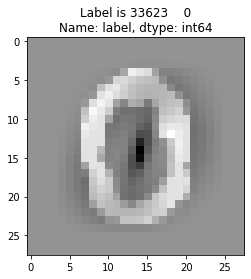

Running LDA on pair :  ('1', '4')


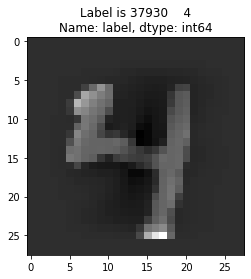

Running LDA on pair :  ('1', '7')


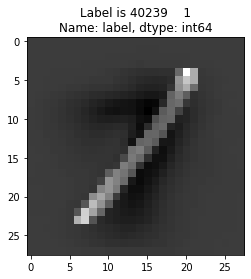

Running LDA on pair :  ('1', '3')


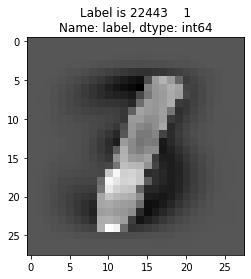

Running LDA on pair :  ('1', '5')


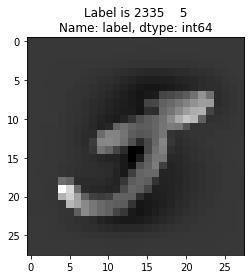

Running LDA on pair :  ('1', '8')


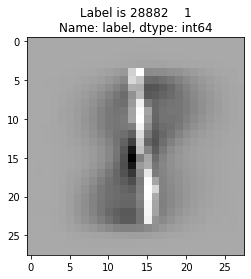

Running LDA on pair :  ('1', '9')


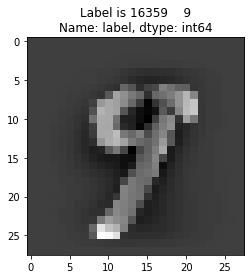

Running LDA on pair :  ('1', '2')


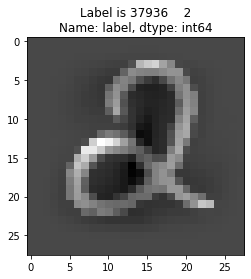

Running LDA on pair :  ('1', '6')


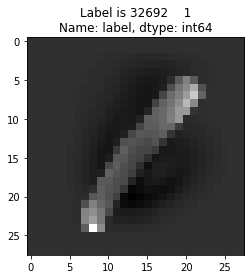

Running LDA on pair :  ('0', '4')


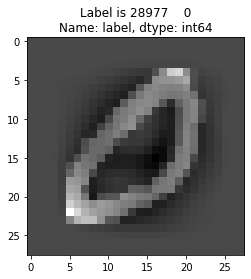

Running LDA on pair :  ('0', '7')


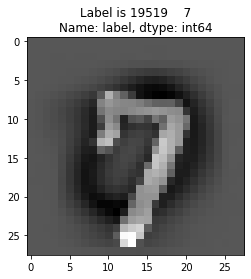

Running LDA on pair :  ('0', '3')


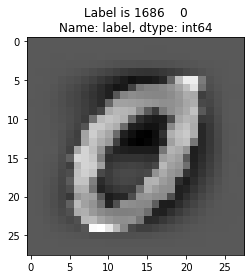

Running LDA on pair :  ('0', '5')


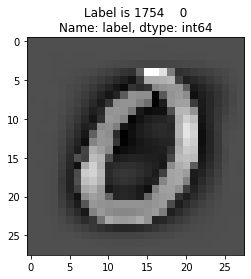

Running LDA on pair :  ('0', '8')


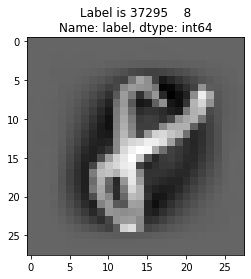

Running LDA on pair :  ('0', '9')


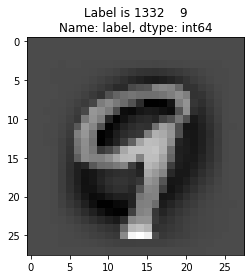

Running LDA on pair :  ('0', '2')


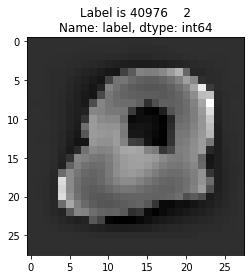

Running LDA on pair :  ('0', '6')


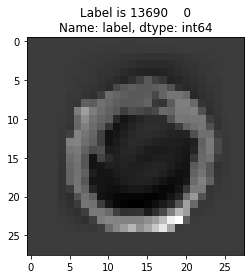

Running LDA on pair :  ('4', '7')


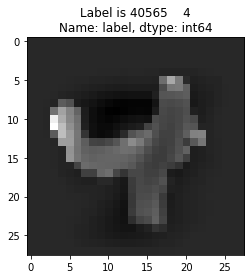

Running LDA on pair :  ('4', '3')


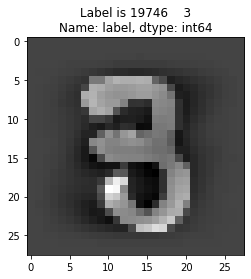

Running LDA on pair :  ('4', '5')


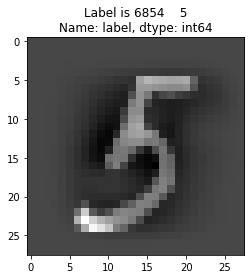

Running LDA on pair :  ('4', '8')


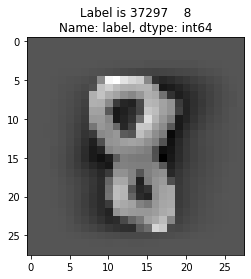

Running LDA on pair :  ('4', '9')


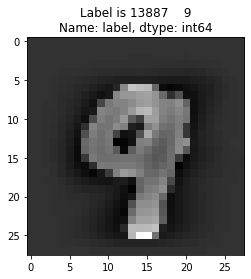

Running LDA on pair :  ('4', '2')


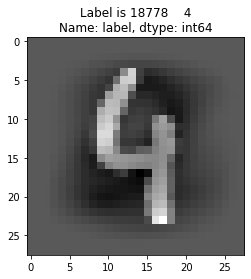

Running LDA on pair :  ('4', '6')


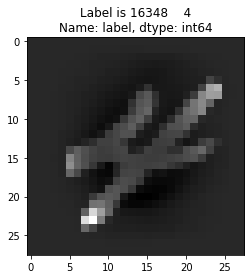

Running LDA on pair :  ('7', '3')


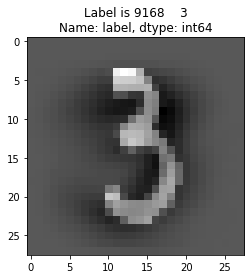

Running LDA on pair :  ('7', '5')


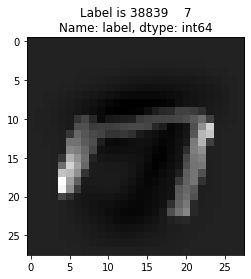

Running LDA on pair :  ('7', '8')


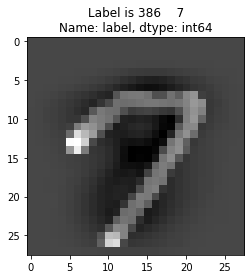

Running LDA on pair :  ('7', '9')


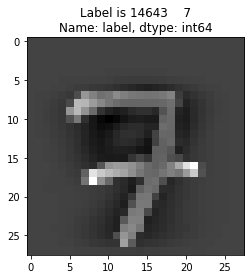

Running LDA on pair :  ('7', '2')


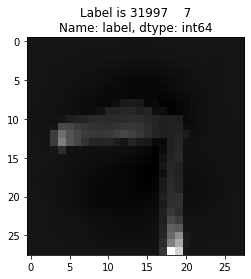

Running LDA on pair :  ('7', '6')


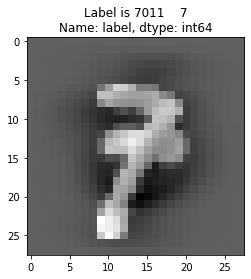

Running LDA on pair :  ('3', '5')


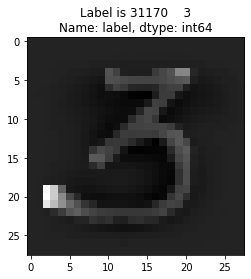

Running LDA on pair :  ('3', '8')


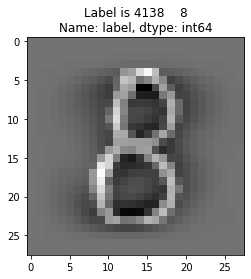

Running LDA on pair :  ('3', '9')


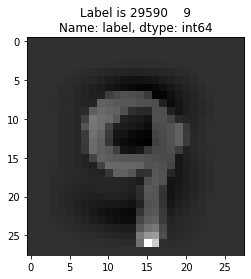

Running LDA on pair :  ('3', '2')


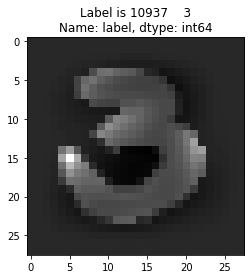

Running LDA on pair :  ('3', '6')


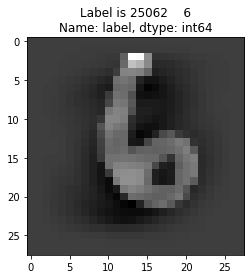

Running LDA on pair :  ('5', '8')


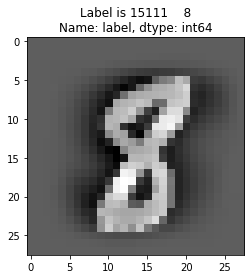

Running LDA on pair :  ('5', '9')


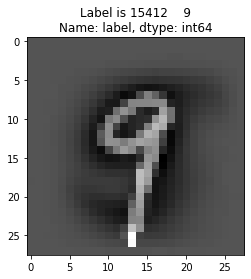

Running LDA on pair :  ('5', '2')


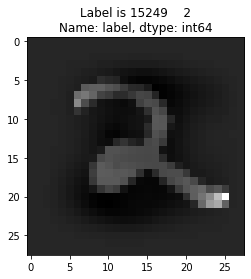

Running LDA on pair :  ('5', '6')


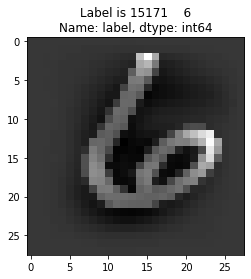

Running LDA on pair :  ('8', '9')


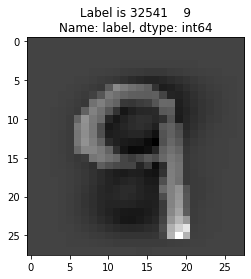

Running LDA on pair :  ('8', '2')


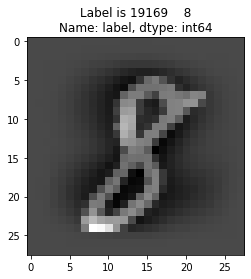

Running LDA on pair :  ('8', '6')


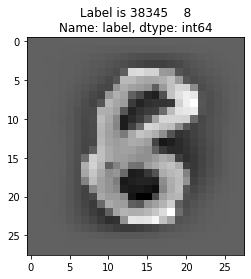

Running LDA on pair :  ('9', '2')


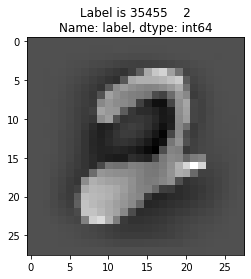

Running LDA on pair :  ('9', '6')


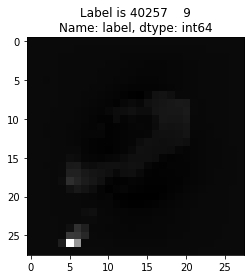

Running LDA on pair :  ('2', '6')


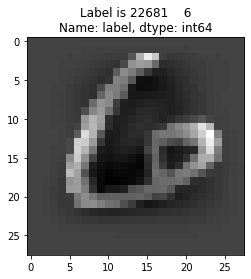

CPU times: user 19min 42s, sys: 6min 45s, total: 26min 27s
Wall time: 26min 45s


In [55]:
%%time

#iterate through all pairs one by one
for pair in all_pairs :
    print("Running LDA on pair : ", pair)
    first_class = int(pair[0])
    second_class = int(pair[1])

    #filter rows for pair of classes
    mnist_temp = mnist[(mnist.label == first_class) | (mnist.label == second_class)]
    mnist_data_temp = mnist_temp.loc[:, mnist_temp.columns != 'label']
    mnist_label_temp = mnist_temp.loc[:, mnist_temp.columns == 'label']
    
    #taking one pixel at a time, 784 features
    for feature in features :
        
        #calculate variance of first class
        mnist_temp_first_class_var = mnist_temp.loc[mnist_temp.label == first_class][feature].values.var()
        #calculate variance of first class
        mnist_temp_second_class_var = mnist_temp.loc[mnist_temp.label == second_class][feature].values.var()
        #calculate sum of variance
        sum_of_var = mnist_temp_first_class_var + mnist_temp_second_class_var
        
        #run LDA if sum of variance is not zero and transform that column data
        if(sum_of_var != 0) :
            #print(feature)
            pixel_data = mnist_temp.loc[:,feature].values.reshape(-1, 1)
            #print(pixel_data)
            model = LinearDiscriminantAnalysis()
            model.fit(pixel_data, mnist_label_temp.values.ravel())
            pixel_fisher_proj_data = model.transform(pixel_data)
            mnist_temp.loc[:,feature] = pixel_fisher_proj_data

    mnist_transformed = mnist_transformed.append(mnist_temp)

    #plot a sample image
    mnist_temp_sample = mnist_temp.sample(1)
    label = mnist_temp_sample.label
    pixels = mnist_temp_sample.iloc[:,1:]
    pixels = pixels.values.reshape((28, 28))

    # Plot image
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

### Comment on fisher discriminant for a few pairs of classes is learning to focus on different pixels in image

#### From above images we see that after fisher projection of pair of classes, the original class shows in foreground and and other class in pair goes in background with a little blur and darker background image

#### original image gets tilted positions in the angle of other class in pair

#### classes 0,2,3,5,8,9 dominate most images because they have overlapping whole area with most possible pairs

#### class pairs like (1,5), (7,5) resulted in complete black pixels because there is very minimal overlapping area between 5 and other numbers

#### class pairs like (9,2), (9,6) resulted in more grey pixels because there is very minimal overlapping area between 9 and 2 or 6 probably

#### Also, pairs which have comparable similar images like (1,7), (1,9) gets more white pixels in similar areas

In [56]:
#Another way to visualize images, however matplot lib gives better images
from PIL import Image
import numpy as np

img = Image.fromarray(pixels, mode='L')
img.show()

## P8 : Binary Heirarchical Classifier

Ref :
- https://www.kaggle.com/nishan192/mnist-digit-recognition-using-svm


In [57]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')

#convert labels to strings, as we will have combined class names going forward for tree building
mnist.label = mnist.label.apply(str)
#print(mnist.sample(5))

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [58]:
#create pair of unique sets
def get_class_pairs(target_names):
    pairs = list(itertools.combinations(target_names, 2))
    return pairs

<h3>
    
Steps followed :
    

Step 1 : Create all unique combination of pairs for all classes in data. Initially it will have 45 pairs for 10 set of classes
    
Step 2 : Run SVD for each pair of classes and get train and test set accuracy. Start with setting up highest accuracy as 100.
    
Step 3 : If test set accuracy is less than 100, choose that pair of classes being marked as lower accuracy.
    
Step 4 : Continue finding lowest accuracy pair, till all pairs are exhausted in current iteration. Also keep printing values if lower accuracy is found.
    
Step 5 : At end of iteration, pair with least accuracy is combined and mnist data is relabeled
    
Step 6 : Repeat Step 1-4, till no. of classes left in data is just 1.
    
</h3>

In [59]:
%%time

from sklearn.preprocessing import scale
from sklearn.svm import SVC

#mnist = mnist[(mnist.label == '1') | (mnist.label == '2') | (mnist.label == '3')]

#initially total classes will be 10 and pairs will be 45
target_names = pd.Series(mnist.label.unique())
pairs = get_class_pairs(target_names)
no_of_classes = target_names.shape[0]

# Consider first pair as minimum accuracy level to start with
lowest_acc_first_class = pairs[0][0]
lowest_acc_sec_class = pairs[0][1]

#define dataframe to store least accuracy classes in each iteration
df = pd.DataFrame(columns=['First Class', 'Second Class', 'Train Accuracy', 'Test Accuracy'])

print("Available class labels : ", target_names.values)
print()

while no_of_classes > 1 :
    highest_accuracy = 100
    print('................ Start with available class labels ................')
    print()
    print("All pairs in current iteration : ", pairs)
    for pair in pairs :
        first_class_in_pair = pair[0]
        second_class_in_pair = pair[1]
        mnist_temp = mnist[(mnist.label == first_class_in_pair) | (mnist.label == second_class_in_pair)]
        #print(mnist_temp.shape)

        X = mnist_temp.loc[:, mnist_temp.columns != 'label'].astype(float)
        y = mnist_temp.loc[:, mnist_temp.columns == 'label']

        # feature scaling
        X_scaled = scale(X)
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 11915043)

        # linear SVM classifier
        model_linear_svm = SVC(kernel='linear')
        model_linear_svm.fit(X_train, y_train.values.ravel())
        train_accuracy = round(metrics.accuracy_score(y_true=y_train, y_pred=model_linear_svm.predict(X_train)),3)
        y_pred = model_linear_svm.predict(X_test)
        test_accuracy = round(metrics.accuracy_score(y_true=y_test, y_pred=y_pred),3)
        if(test_accuracy < highest_accuracy) :
            lowest_acc_first_class = first_class_in_pair
            lowest_acc_sec_class = second_class_in_pair
            highest_accuracy = test_accuracy
            print("Pair with lower accuracy in current iteration : (", pair[0], "," , pair[1], "), ",
                 "Train accuracy : ", train_accuracy, ", Test Accuracy : " ,test_accuracy)
    
    df = df.append({'First Class':lowest_acc_first_class, 'Second Class' :lowest_acc_sec_class,
               'Train Accuracy':train_accuracy, 'Test Accuracy':test_accuracy}, ignore_index=True)
    
    #Now, update the class labels
    updated_class_label = lowest_acc_first_class + '_' + lowest_acc_sec_class
    mnist.loc[(mnist.label == lowest_acc_first_class) | 
              (mnist.label == lowest_acc_sec_class), 'label'] = updated_class_label
    target_names = pd.Series(mnist.label.unique())
    no_of_classes = target_names.shape[0]
    print("Done with iteration, Updated class labels : ", target_names.values)
    print()
    pairs = get_class_pairs(target_names)

Available class labels :  ['1' '0' '4' '7' '3' '5' '8' '9' '2' '6']

................ Start with available class labels ................

All pairs in current iteration :  [('1', '0'), ('1', '4'), ('1', '7'), ('1', '3'), ('1', '5'), ('1', '8'), ('1', '9'), ('1', '2'), ('1', '6'), ('0', '4'), ('0', '7'), ('0', '3'), ('0', '5'), ('0', '8'), ('0', '9'), ('0', '2'), ('0', '6'), ('4', '7'), ('4', '3'), ('4', '5'), ('4', '8'), ('4', '9'), ('4', '2'), ('4', '6'), ('7', '3'), ('7', '5'), ('7', '8'), ('7', '9'), ('7', '2'), ('7', '6'), ('3', '5'), ('3', '8'), ('3', '9'), ('3', '2'), ('3', '6'), ('5', '8'), ('5', '9'), ('5', '2'), ('5', '6'), ('8', '9'), ('8', '2'), ('8', '6'), ('9', '2'), ('9', '6'), ('2', '6')]
Pair with lower accuracy in current iteration : ( 1 , 0 ),  Train accuracy :  1.0 , Test Accuracy :  0.998
Pair with lower accuracy in current iteration : ( 1 , 4 ),  Train accuracy :  1.0 , Test Accuracy :  0.997
Pair with lower accuracy in current iteration : ( 1 , 7 ),  Train accurac

Pair with lower accuracy in current iteration : ( 0 , 6 ),  Train accuracy :  1.0 , Test Accuracy :  0.985
Pair with lower accuracy in current iteration : ( 4_7_9_3_5_8_2 , 6 ),  Train accuracy :  0.993 , Test Accuracy :  0.981
Done with iteration, Updated class labels :  ['1' '0' '4_7_9_3_5_8_2_6']

................ Start with available class labels ................

All pairs in current iteration :  [('1', '0'), ('1', '4_7_9_3_5_8_2_6'), ('0', '4_7_9_3_5_8_2_6')]
Pair with lower accuracy in current iteration : ( 1 , 0 ),  Train accuracy :  1.0 , Test Accuracy :  0.998
Pair with lower accuracy in current iteration : ( 1 , 4_7_9_3_5_8_2_6 ),  Train accuracy :  0.998 , Test Accuracy :  0.987
Pair with lower accuracy in current iteration : ( 0 , 4_7_9_3_5_8_2_6 ),  Train accuracy :  0.997 , Test Accuracy :  0.986
Done with iteration, Updated class labels :  ['1' '0_4_7_9_3_5_8_2_6']

................ Start with available class labels ................

All pairs in current iteration :  [(

In [60]:
#Code block taken directly from stackoverflow as it is released under CCA license and appropriately cited here
#Ref : https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209

import networkx as nx
import random

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

#### Prepare array from dataframe containing train and test accuracy to plot

In [61]:
temp_items = []
for index, row in df.iterrows():
    combined = row['First Class'] + '_' + row['Second Class']
    temp_items.append((combined, row['First Class']))
    temp_items.append((combined, row['Second Class']))
    #print(row['First Class'], row['Second Class'])

df

,First Class,Second Class,Train Accuracy,Test Accuracy
0,5,8,1.000,0.975
1,3,5_8,1.000,0.975
2,7,9,1.000,0.975
3,3_5_8,2,1.000,0.975
4,4,7_9,0.994,0.978
5,4_7_9,3_5_8_2,0.994,0.978
6,4_7_9_3_5_8_2,6,0.993,0.981
7,0,4_7_9_3_5_8_2_6,0.997,0.986
8,1,0_4_7_9_3_5_8_2_6,0.998,0.988


### Plot Tree from dataframe of train and test accuracies at each level prepared above

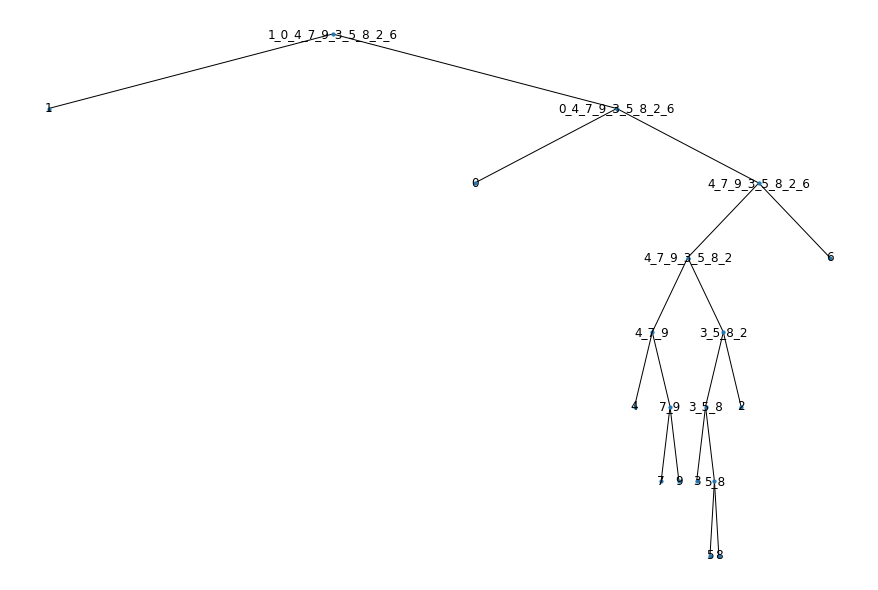

In [62]:
import networkx as nx

graph = nx.Graph()
#add all combinations found at each level
graph.add_edges_from(temp_items)

#top node need to be specified to start the tree from data above
#then it takes a hierachy learned
pos = hierarchy_pos(graph,'1_0_4_7_9_3_5_8_2_6')
#increase graph size
plt.figure(3, figsize=(12,8)) 
nx.draw(graph, pos=pos, with_labels=True, node_size=10,font_size=12)
plt.show()